Recurrent Neural Network model for regression in sequences
====

In this example we will use the RNNModel to set up an experiment over one of the Spice (http://spice.lif.univ-mrs.fr/index.php) competence for sequence prediction, held in 2016. We will start by downloading and preprocessing the dataset.

In [1]:
%matplotlib inline

ORIGIN_URL = 'http://spice.lif.univ-mrs.fr/data/1.spice.train'
DATASET_DIR = 'downloads'
DATASET_FILENAME = 'spice_dataset.txt'

In [2]:
# add parent directory to python path
import sys
sys.path.append('../')

In [3]:
import numpy
import os
import urllib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import utils
utils.safe_mkdir(DATASET_DIR)

In [5]:
def maybe_download():
    """Downloads dataset if it doesn't exists"""
    filename = os.path.join(DATASET_DIR, DATASET_FILENAME)
    if os.path.exists(filename):
        return
    urllib.urlretrieve(ORIGIN_URL, filename)

maybe_download()

The dataset file consists on a series of numerical sequences, one per line, including a header line that we will ignore. We will try to predict the last element of each sequence. 

In [61]:
from sklearn.preprocessing import OneHotEncoder


def get_instances(elements, sequences):
    """Converts the elements to one hot encodings and divides them according to sequences."""
    encoder = OneHotEncoder()
    elements = encoder.fit_transform(elements)
    instances = []
    for start, end in sequences:
        instances.append(elements[start:end])
    return instances


def read_dataset():
    """Reads the dataset. Returns a list with sequences and a list of labels"""
    with open(os.path.join(DATASET_DIR, DATASET_FILENAME), 'r') as input_file:
        lines = input_file.readlines()[1:]  # Ignore the header
    # Split lines and convert numbers to one hot encodings.
    sequences = []  # A list with start, end of each sequence.
    elements = []
    labels = []
    current_start = 0
    for line in lines:
        values = line.split()
        # We discard the first element (sequence lenght) and the last one (sequence label)
        sequences.append((current_start, current_start + len(values) - 2))
        current_start += len(values) - 2
        for value in values[1:-1]:
            elements.append([int(value)])
        labels.append(values[-1])
    instances = get_instances(elements, sequences)
    return numpy.array(instances), numpy.array(labels)

In [62]:
instances, labels = read_dataset()

In [68]:
import scipy
isinstance(instances[1], scipy.sparse.csr_matrix) 

True

We can now create the dataset using the extracted instances and labels

In [91]:
import dataset
dataset = reload(dataset)

samples = 1
partition_sizes = {'train': 0.7, 'test': 0.2, 'validation': 0.1}

splice_dataset = dataset.SequenceDataset()
splice_dataset.create_samples(instances, labels, samples, partition_sizes, use_numeric_labels=True)

In [92]:
import experiment
experiment = reload(experiment)
from models import lstm, mlp
mlp = reload(mlp)
lstm = reload(lstm)

config = {
    'model': lstm.LSTMModel,
    'model_arguments': {'hidden_layer_size': 10, 'batch_size': 500,
                        'logs_dirname': '../../results/examples/splice/',
                        'log_values': True, 'training_epochs': 500, 'max_num_steps':50}
}
splice_experiment = experiment.SampledExperiment(splice_dataset, config=config)

In [93]:
tf.reset_default_graph()
splice_experiment.run()

INFO:root:Classifier loss at step 0: 2.99519324303
INFO:root:Validation accuracy 0.255127563782
INFO:root:Classifier loss at step 100: 2.88340950012
INFO:root:Validation accuracy 0.147073536768
INFO:root:Classifier loss at step 200: 2.86117815971
INFO:root:Validation accuracy 0.147073536768
INFO:root:Classifier loss at step 300: 2.86590480804
INFO:root:Validation accuracy 0.147073536768
INFO:root:Classifier loss at step 400: 2.8634455204
INFO:root:Validation accuracy 0.147073536768
INFO:root:
	Precision	Recall	F1 Score
mean	0.158	0.158	0.158
std	0.0	0.0	0.0


We are obtaining a very low accuracy, let's see what's going on...

In [94]:
predictions = splice_experiment.model.predict('test')

In [99]:
print predictions, numpy.unique(predictions, return_counts=True)

[7 7 7 ..., 7 7 7] (array([ 7, 16]), array([3999,    1]))


In [96]:
splice_dataset.datasets['test'].labels

array([14,  4,  8, ...,  8, 10, 17])

In [97]:
splice_experiment.model.dataset._classes

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '3', '4', '5', '6', '7', '8', '9'], 
      dtype='|S2')

A majority class is taken over the other, let's see the class distribution in test and train datasets.

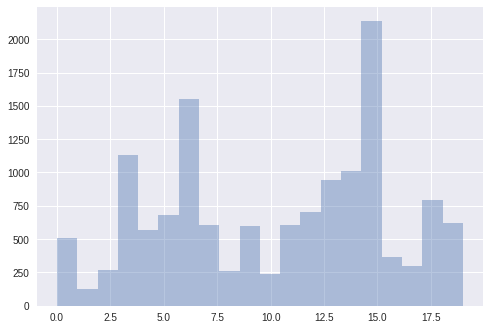

In [18]:
sns.distplot(splice_dataset.datasets['train'].labels, kde=False, bins=20)

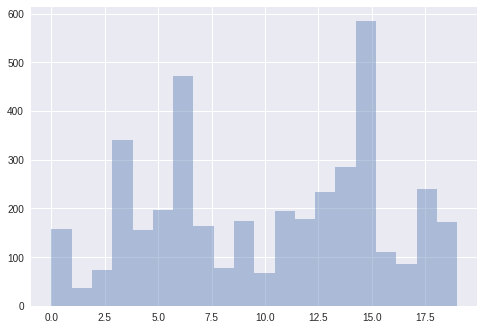

In [19]:
sns.distplot(splice_dataset.datasets['test'].labels, kde=False, bins=20)

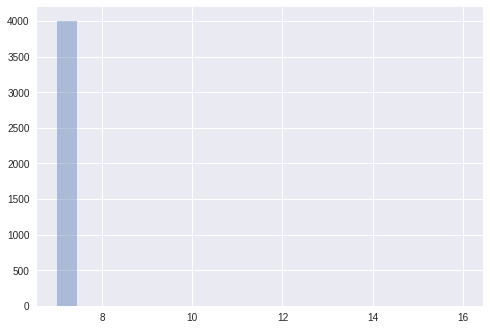

In [98]:
sns.distplot(predictions, kde=False, bins=20)